In [1]:
import sys, os, itertools, numpy as np
sys.path.insert(0, os.path.expanduser("~/Documents/UW/Research/Development"))

def reload():
    from McUtils.Jupyter import ModuleReloader
    if 'McUtils' in sys.modules:
        ModuleReloader('McUtils').reload()
        ModuleReloader('McUtils.McUtils').reload()

from McUtils.Jupyter import *

---
title: Better Docs with JHTML
date: 2022-10-15
permalink: better-docs-with-jhtml
tags: python jupyter
---

## What's New with JHTML

The last post I wrote was about a framework I had just written allowing rich DOM access through Jupyter widgets.
Since writing that, the framework has grown tremendously, including pretty much every feature one might expect from Bootstrap, including the basic nice formatting things like `Cards` and `Buttons` along with richer elements like `Carousels`, `Tabs`, `Popovers`, and `Toasts`, and layout utilities like `Flex` and `Grid`.
This is on top of the richer interactivity that already existed through the use of dynamic variables and functions through the `VariableDisplay` and `FunctionDisplay` elements.

That means it was easy for me to write my own `Manipulator` object to mimic Mathematica's `Manipulate` function.
So now for example we can define a little plotting function

In [8]:
import McUtils.Plots as plt
import numpy as np

def plot_sin(*, x, x_min=-.005, **_):
    x_max = x if isinstance(x, (int, float)) else 0
    x_min = x_min if isinstance(x_min, (int, float)) else -.005
    return plt.Plot(
        np.sin,
        [x_min, x_max, (x_max-x_min)/70],
        plot_range=[[x_min, 2*355/113], [-1.05, 1.05]],
        image_size=(600, 250),
    )

and we can play with it easily

In [10]:
Manipulator(
    plot_sin,
    ("x", {'range': [0, 2*355/113, .001], 'continuous_update': True}),
    ("x_min", {'range': [-2*355/113, 0, .001], 'continuous_update': True}),
    width='600px',
    theme={'output': {'height': '250px'}},
    header='SinPlot'
)

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, 'SinPlot', cls=['card-header'], style={}), HTMLElement(di…

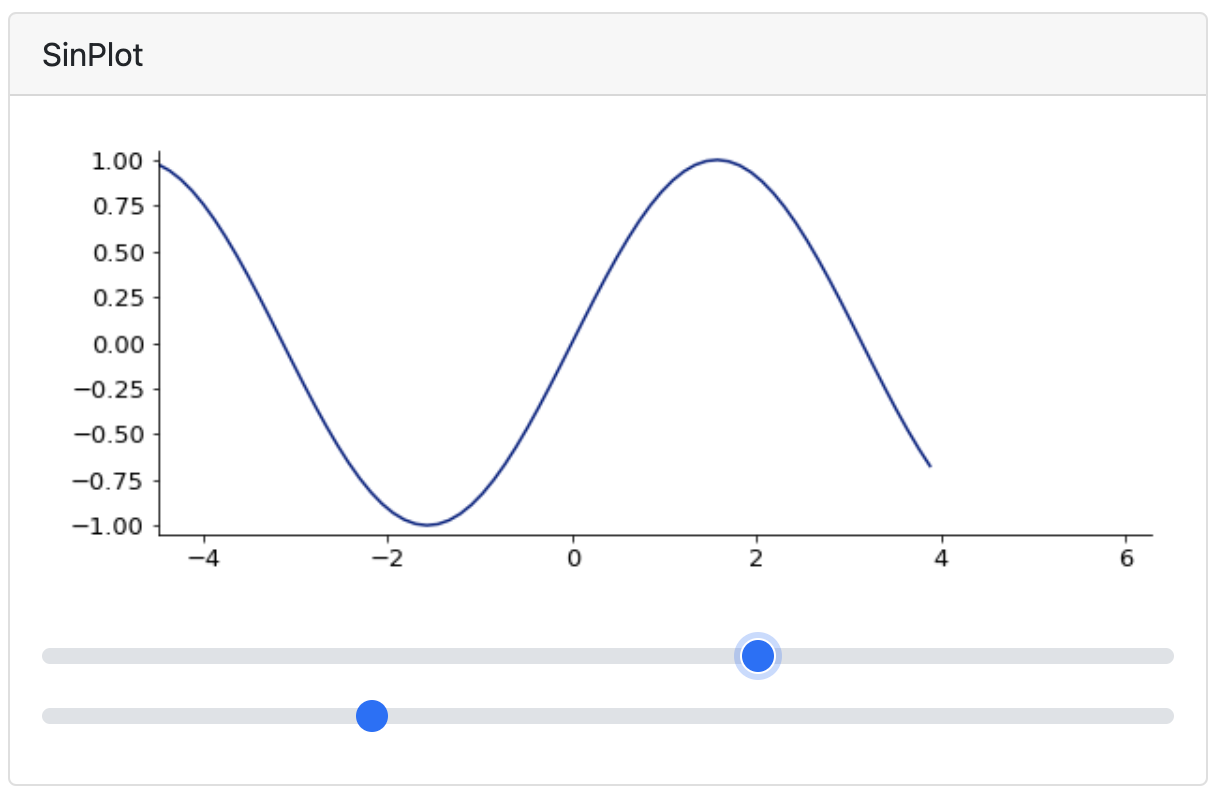

and you can play with the parameters just like a regular `Manipulate`.

Now, there's certainly room for improvement in this interface, but the fact that it was <25 lines of code to create this completely general `Manipulator` is a win in my book.

The system also now supports a way to register Javascript callbacks that can be used to get even richer interactions, for instance, we can easily have some buttons that pop up alerts when we click them through the Javascript `alert` system

In [15]:
ButtonGroup(
    ['a', 'b', 'c'],
    event_handlers={'click':'sayHi'},
    javascript_handles={'sayHi':'alert("Hi")'}
)

HTMLElement(div, (HTMLElement(div, (HTMLElement(button, 'a', cls=['btn', 'btn', 'btn-primary'], style={}), HTM…

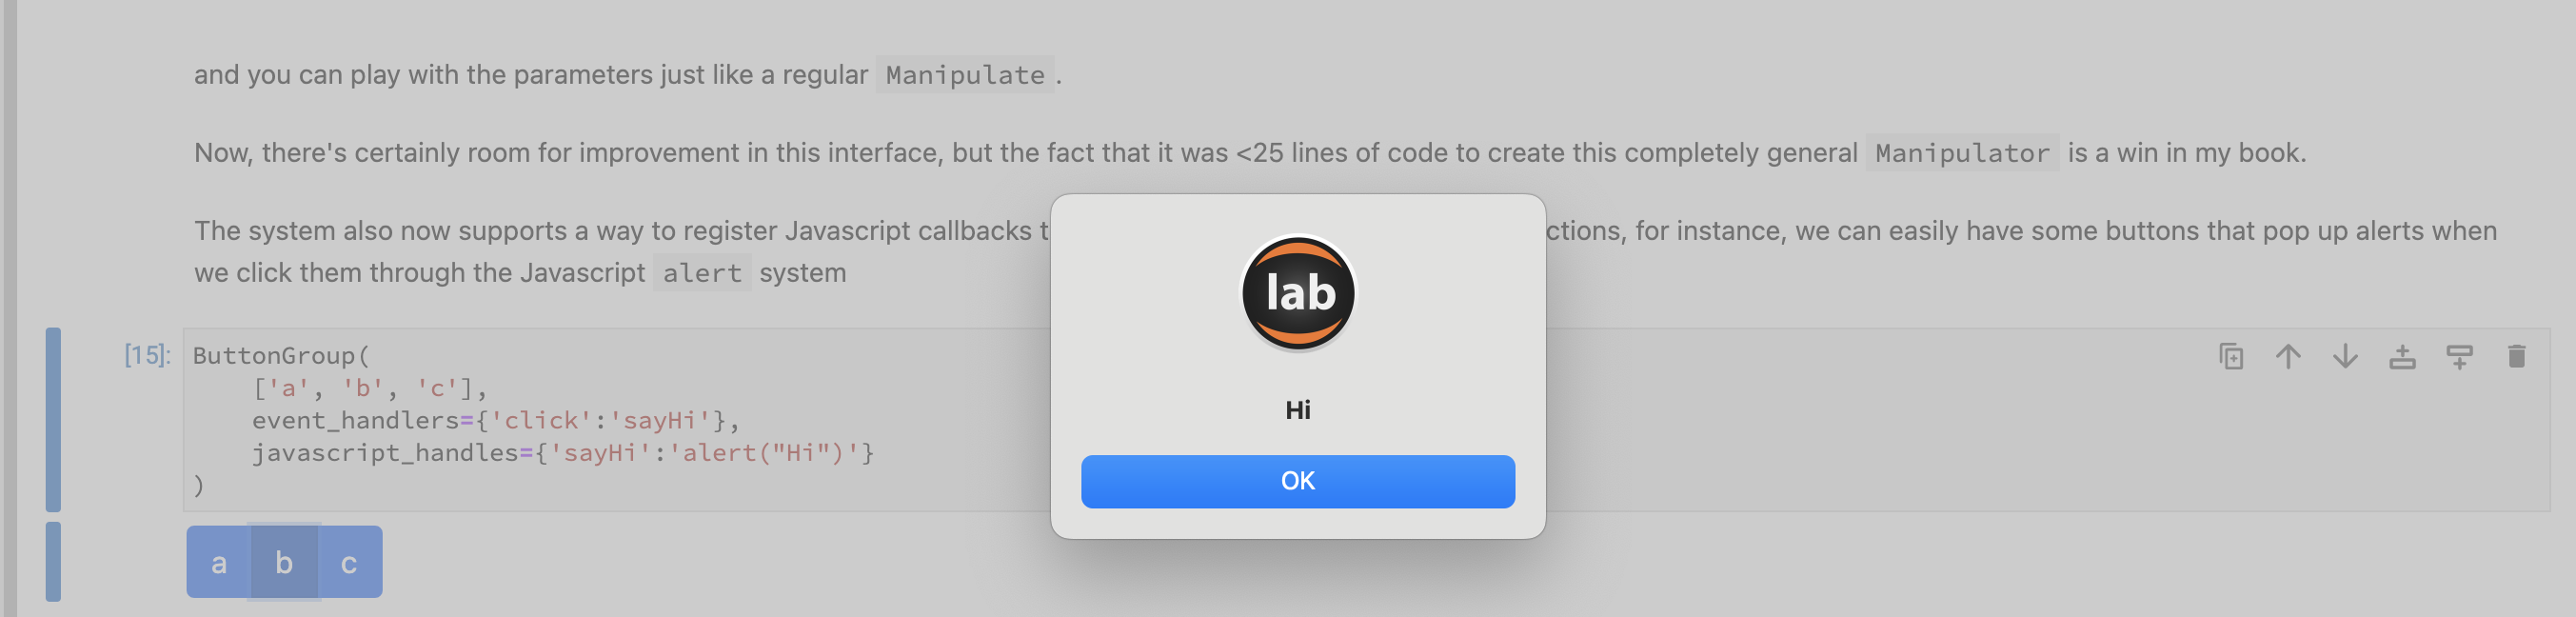

We can also register handles to fire on _events_ through the `onevents` keyword. Here's the same example from above, except now it will fire when the interface element is both initially displayed and when it is removed.

In [ ]:
ButtonGroup(
    ['a', 'b', 'c'],
    onevents={'initialize':'sayHi', 'remove':'sayHi'},
    javascript_handles={'sayHi':'alert("Hi")'}
)

Or going even further, if we've allowed JupyterLab to get out location, we can make a Javascript API to query that

In [2]:
api = JHTML.JavascriptAPI(
   nope="""alert(event.content['message'])""",
   cb="""
navigator.geolocation.getCurrentPosition((pos)=>this.send({type:'geoloc', pos:[pos.coords.latitude, pos.coords.longitude]}), (e)=>{throw e})
"""
)

where we first query the GeoLocation via `navigator.geolocation.getCurrentPosition` and then we can emit a message containing that data by calling `this.send({type:'geoloc', pos:[pos.coords.latitude, pos.coords.longitude]})` which will send a `geoloc` message which we can then listen for with an `onevent`. This gives us one (but by no means the only) route to get data from the Javascript side--the other reccomended route is to use the `data` field of a `widget` which can pass a dict of data, but that's for another day.

Now we can call our API to get out the location and once the message with it comes in we can handle that message appropriately

In [ ]:
with JHTML() as j:
    b = JHTML.Bootstrap.Button("Get Location", 
                               event_handlers={"click":"cb", 'geoloc':lambda e,w:print(e['pos'])}, 
                               javascript_handles=api
                              )
    d = JHTML.Div(b, j.out)
d

HTMLElement(div, (HTMLElement(div, (HTMLElement(button, 'Get Location', cls=['btn', 'btn-primary'], style={}),…

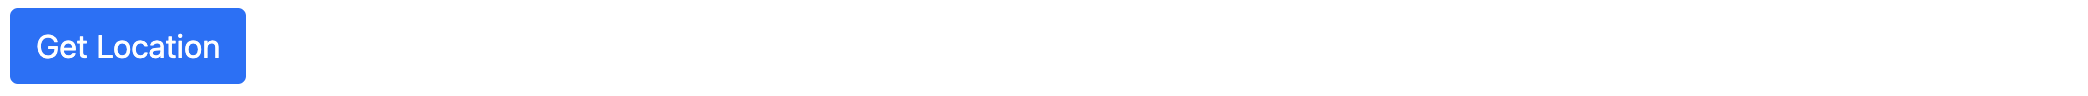

We can do even crazier things, too, like creating an editable `Canvas`

In [6]:
JHTML.Canvas(
    dynamic=True,
    width='500px',
    height='500px',
    cls='border',
    id='my-drawing',
    onevents={'initialize':'init'},
    javascript_handles={
        "init":"""
if (!widget.hasOwnProperty('ctx')) {
 widget.ctx = widget.el.getContext('2d');
 widget.el.width = 1024;
 widget.el.height = 1024;
}
""",
        "setPosition":"""
widget.pos = { x: event.clientX, y: event.clientY };
let bounds = widget.el.getBoundingClientRect();
// get the mouse coordinates, subtract the canvas top left and any scrolling
widget.pos.x = event.pageX - bounds.left - scrollX;
widget.pos.y = event.pageY - bounds.top - scrollY;
// first normalize the mouse coordinates from 0 to 1 (0,0) top left
// off canvas and (1,1) bottom right by dividing by the bounds width and height
widget.pos.x /= bounds.width; 
widget.pos.y /= bounds.height; 
// then scale to canvas coordinates by multiplying the normalized coords with the canvas resolution
widget.pos.x *= widget.el.width;
widget.pos.y *= widget.el.height;
""",
        "draw":"""
if (event.buttons === 1){
  widget.ctx.beginPath();
  widget.ctx.moveTo(widget.pos.x, widget.pos.y);
  widget.callHandler("setPosition", event);
  widget.ctx.lineTo(widget.pos.x, widget.pos.y);
  widget.ctx.stroke();
  }
  """
    },
    event_handlers={
        'mouseenter':'setPosition', 
        'mousedown':'setPosition', 
        'mousemove':'draw'
    }
)

HTMLElement(div, (HTMLElement(canvas, '', cls=['border'], style={'width': '500px', 'height': '500px'}),), cls=…

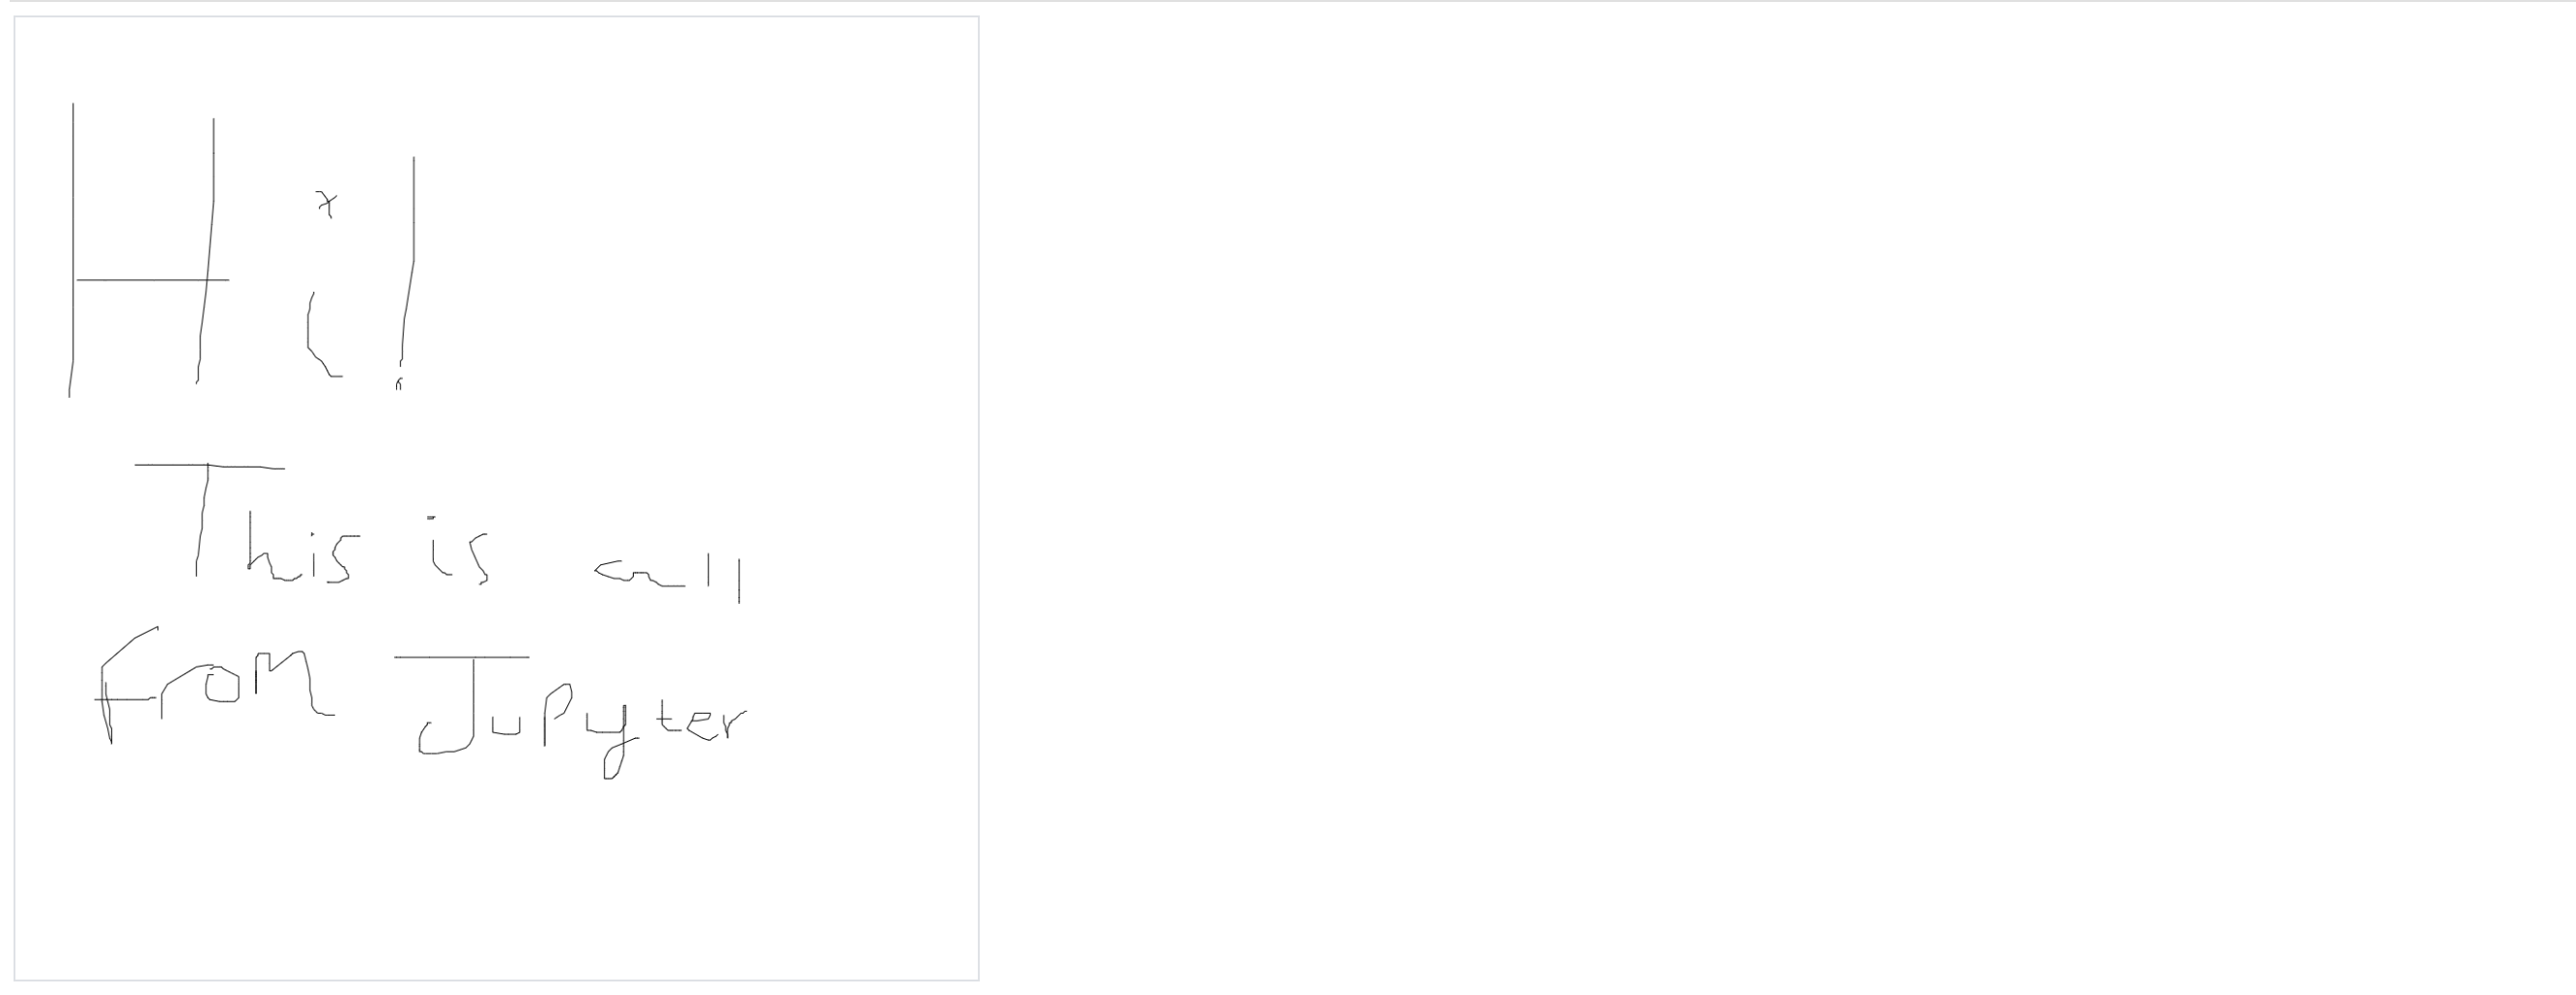

But at some level none of that is particularly useful in my day to day as a scientist and programmer. My real goal with this post was to talk about something that really pays dividends for my work--better documentation.

## Documentation Should Thrive in a Notebook

I find writing documentation to be incredibly painful. I think this is partially because I don't get a quick dopamine hit for making documentation changes and partially because I don't really use what I write. The benefits all go to a nebulous set of users who I'm not even sure exist as for me it's just as easy to go into my code base itself as it is to go online to my docs. But by bringing docs into Jupyter, I can hopefully change both of those. This isn't to say that Jupyter doesn't already do docs, for example, here's how it handles learning about `JHTML`

In [7]:
?JHTML

Init signature:
JHTML(
    context=None,
    include_bootstrap=False,
    expose_classes=False,
    output_pane=True,
    callbacks=None,
    widgets=None,
)
Docstring:     
Provides dispatchers to either pure HTML components or Widget components based on whether interactivity
is required or not
File:           ~/Documents/UW/Research/Development/McUtils/McUtils/Jupyter/JHTML/JHTML.py
Type:           type
Subclasses:     


This isn't bad, per se, but it could be much better. For contrast, [here](https://mccoygroup.github.io/McUtils/McUtils/Jupyter/JHTML/JHTML/JHTML.html) is what my online docs look like for the same

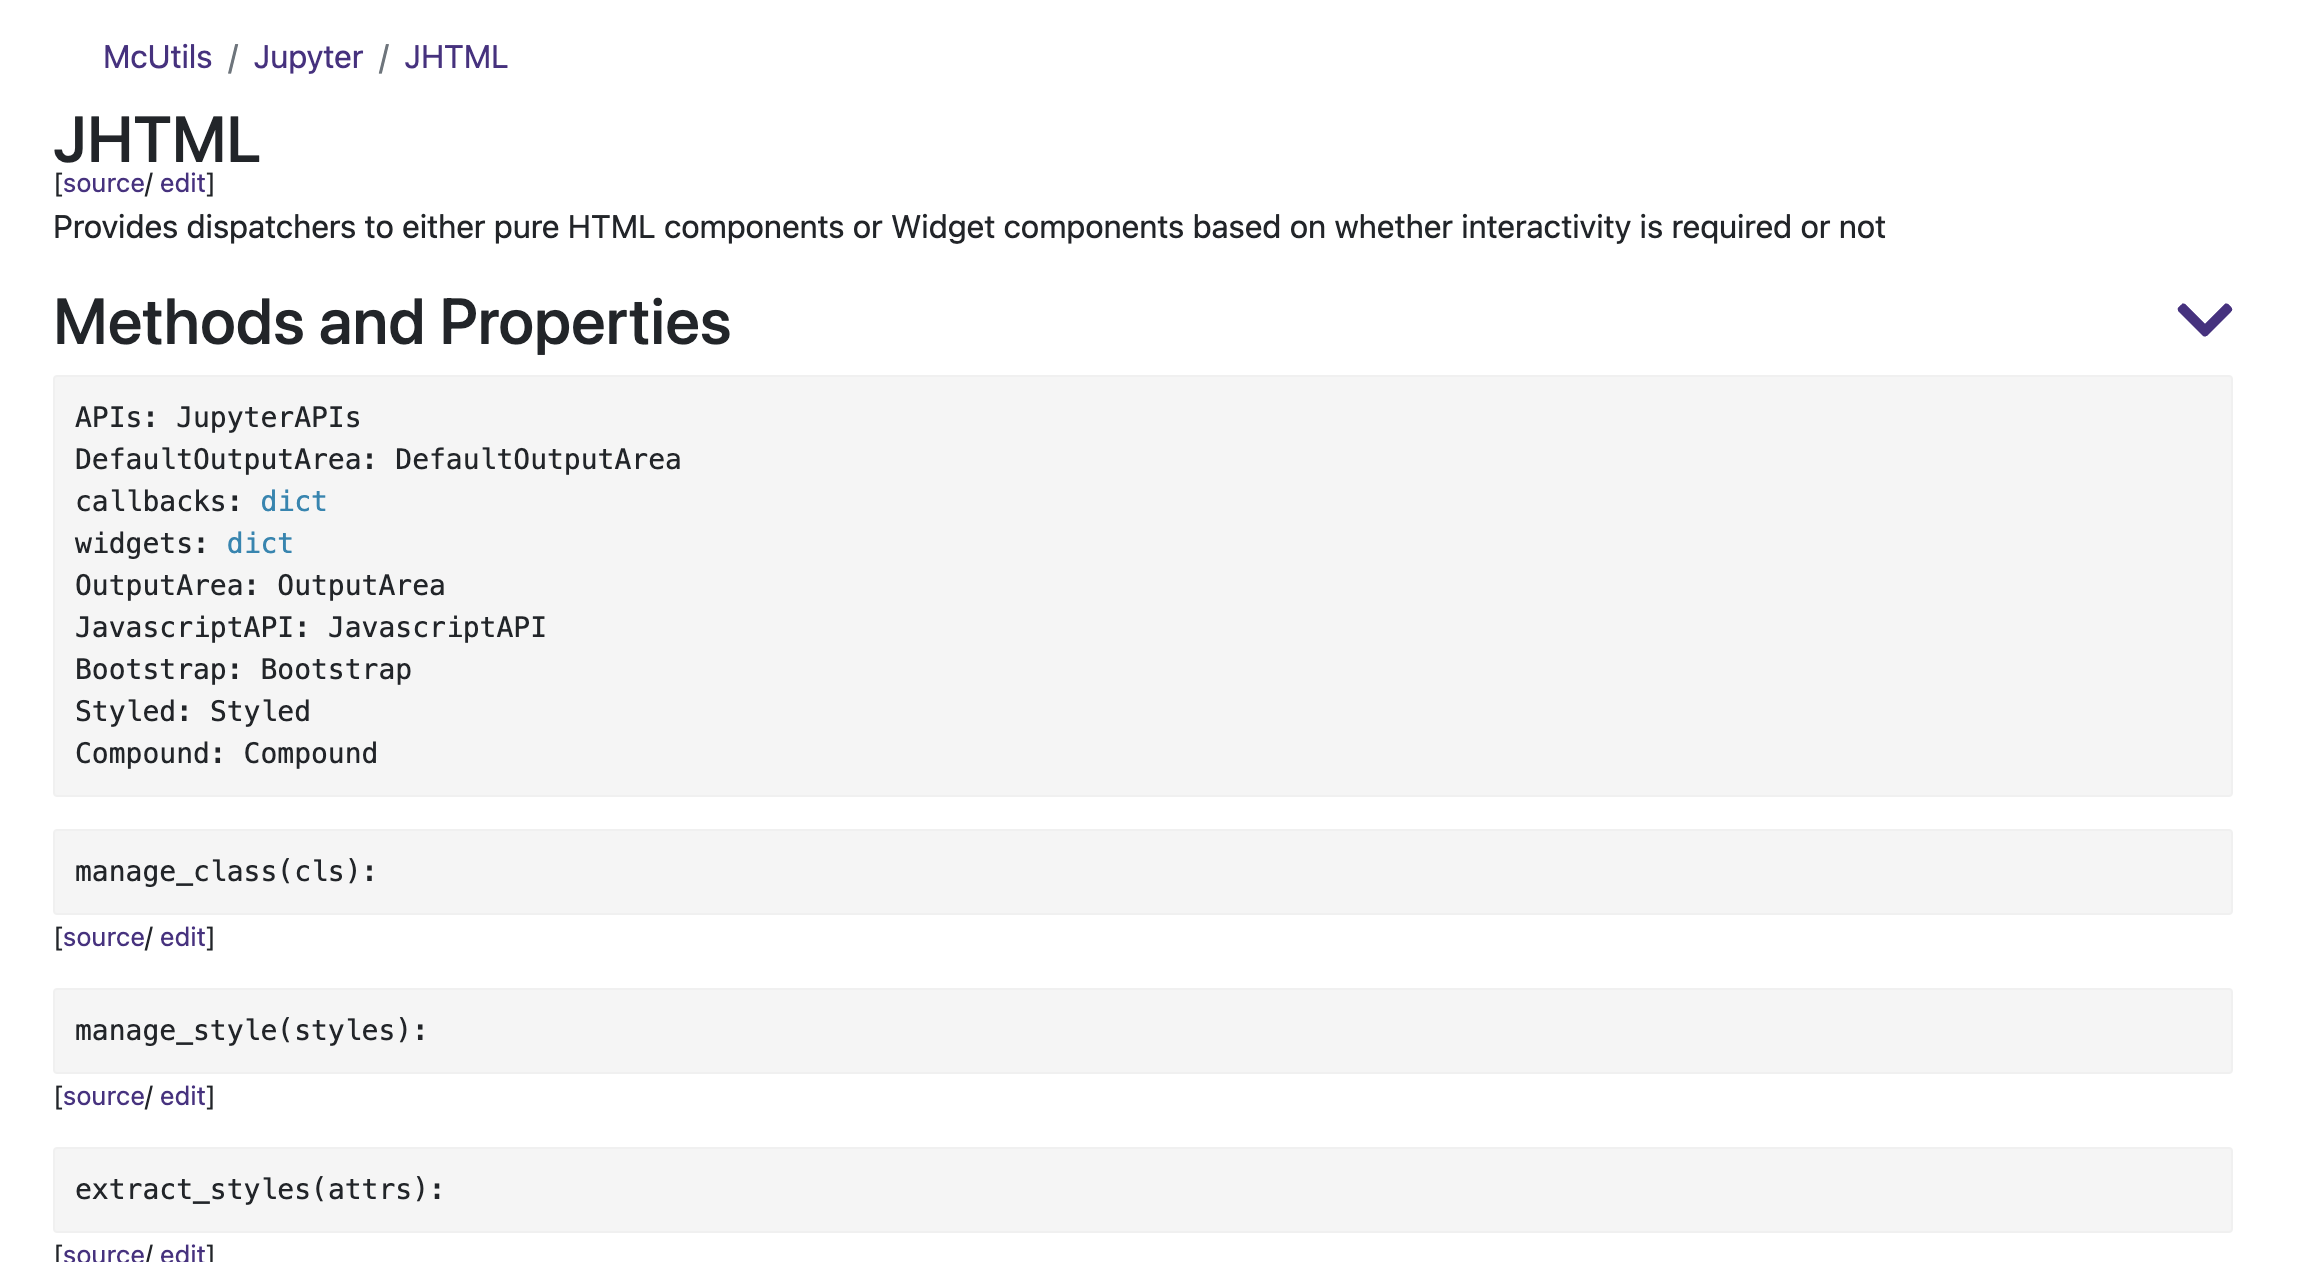

There's much more detail and everything is interactable, including source links and (if I'd actually bothered to write them) examples and links to related functions and classes.

The question now is how we bring this to Jupyter.

### Extending `Peeves.Doc`

Happily(?), I rolled my own documentation generator. I didn't like the docstring format or the appearance of Sphinx docs and figured I knew I'd always want more so I really had to build what I wanted. This is actually a pretty easy task, all told. The necessary ingredients are

1. A system for walking through object trees, digging down through modules' members, classes methods, and so forth
2. A docstring parser and resource locator for examples a unit tests
3. A formatting system for turning the parsed components into a final format

The first part is very easy to write. The second just requires a standard format. My choice has been to use a Markdown-style docstring but use reStructured text declarations of parameters and parameter types. This format can obviously be tweaked though, since the all of the parsers can be subclassed and reused in the walker object that implements (1). As for part (3), when building for the web I had to write a template engine to generate Markdown docs from `.md` templates (with some significant extensions to python's default `string.format` mechanism). On the other hand, when targeting a Jupyter-style interface I get to use all of my JHTML tricks.

In practice, this means I end up with something that can be displayed directly in the notebook and can be interacted with in a very natural way. For example, documentation for module members is generated on demand, each bit of documentation links to its source, `Related` functions/classes can be linked to and will replace the current piece of documentation in the active browser, and I'm sure I'll come up with more.

But before the system was truly a solid replacement for Jupyter's built-in docstring mechanism I needed one final thing. Jupyter's docstring printing is called through the `?` operator. I wanted my documentation to be accessible via the same. That meant I needed to do a bit of monkey patching though, as the default `?` mechanism calls `pinfo` in the `IPython` kernel but `pinfo` supplies no extra hooks that package writers can use. So I wrote a function `patch_pinfo` that would make it so that `pinfo` did just that and now whatever is returned from an object's `_ipython_pinfo_` method will be displayed when using `?` which means I can do this:

In [ ]:
?DocWalker

<video autoplay>
<source 
        src="{{site.url}}/img/better-doc-with-jhtml-docs_example.mp4"
        type="video/mp4">
</video>

# Export

In [18]:
from McUtils.Jupyter import ModuleReloader
if 'McUtils' in sys.modules:
    ModuleReloader('McUtils').reload()
    ModuleReloader('McUtils.McUtils').reload()
from McUtils.Jupyter import NotebookExporter

NotebookExporter('2022-10-15-Better Docs with JHTML',
                img_dir=os.path.join(os.path.dirname(os.getcwd()), 'img'),
                img_prefix='{{site.url}}/img/'
                ).export();